## LB Drives - Machine Learning Analysis (work in progress)

### Background
![drive](img/drive.jpg)
The mill is developing an initiative to monitor the state of drives being used in the paper making process via mathematically analysing the stream of key process variables. Depending on the condition of the drive, given by some key variables associated with each individual equipment, the system triggers a maintenance notification. While the notification is open, the variable status gets a value that shows it is under maintenance. When the notification is closed, the variable status gets back to normal. 


### Data available

Two excel files were generated with information related to several drives during the period of one month with one observation per minute. The input file shows a bigger subset of the drives available in the mill. The output file include 10 drivers under the monitoring initiative with its condition state (normal or under maintenance).

### The approach

We split the output and input data into separate files and then combine the variables that indicate the condition of the equipment. While we combine the variables together, we check for data that is invalid (eg text in numerical values), missing values etc. This is an important step to guarantee the model will work as expected. 

Next, we apply a machine learning technique to try to create a model for each drive that could reflect the combined state of the variables impacting the equipment condition. During this process, we will also try to predict the condition of the equipment using a generic model (based on one the equipment only). 

### How to interpret the results

We will generate the models using a classification method called random decision trees (random forest/extra trees). After the model is created, we use it to predict the variable status based on out of the sample data (variables about the condition of the equipment). 

We are randonly splitting the data, with observations from 30 days, into training and test data with a proportion of 70/30. The metrics are calculated comparing the real data with the prediction data so that we can estimate how reliable the model is. For that, we can use the metrics accuracy, precision and recall. In general, rates close to 1 indicate an excellent prediction result. The Confusion Matrix shows the overall picture of those metrics, indicating what was measured right and wrong (true positives, true negatives, false positives and false negatives). 

Finally, we list the most important variables that collaborated to create the model. This provides an insight on what information is relevant for the prediction step. 


### The main code and the results

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  7 09:01:16 2016
@author: DEDUS-RobertoMa
"""
%matplotlib inline
#initialization of libraries
from __future__ import print_function
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import glob
import itertools
#scikit learn functions
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# Configure here for your local machine
base_data_path = "/Users/rerngvit/Dropbox/coding_workspace/analytic-workspace/combient/poc_stora_lb_drives/data/individual_drives/"
preparation_path = "/Users/rerngvit/Dropbox/coding_workspace/analytic-workspace/combient/poc_stora_lb_drives/data/preparation/"
model_data_path = "/Users/rerngvit/Dropbox/coding_workspace/analytic-workspace/combient/poc_stora_lb_drives/data/building_model/"

//anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#%% function to print and plot the confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')
    #print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [3]:
#%% preprocessing 
def process_drive_file(drive_name, seq):  
    df_in = pd.read_excel(base_data_path + "input_"+drive_name+".xlsx")
    df_in.index = df_in.index.strftime("%Y-%m-%d %H:%M:%S")
    df_out = pd.read_excel(base_data_path +  "output_"+drive_name+".xlsx")
    df_out.index = df_out.index.strftime("%Y-%m-%d %H:%M:%S")
    df = pd.concat([df_in, df_out], axis=1)
    for filename in glob.iglob(base_data_path + 'input*'+drive_name+'*'):
        # Loading, preprocessing and splitting tasks /one drive to test the ml approach     
        name = re.search('LM.+\.drv',filename).group(0)
        var_status = name+'_status'
        print("\n",seq,"- Drive:", name)
        df_train = df
        df_train.to_excel(preparation_path + name+"_df_train.xlsx")
        var_remove1 = name+"_Temperatuur_ER"
        var_remove2 = name+"_Run_Feedback"
        #print("Before row conditions remove:",df_train.shape)    
        df_train = df_train.drop([var_remove1], axis=1)
        df_train = df_train.drop([var_remove2], axis=1)
        df_train = df_train[df_train[name+"_Koppel"] != 'Intf Shut']
        df_train = df_train[df_train[name+"_Frequentie"] != 'Intf Shut']
        df_train = df_train[df_train[name+"_Frequentie"] != 'I/O Timeout']
        df_train = df_train[df_train[name+"_Koppel"] != 'Scan Timeout']
        #print("after forth row condition remove:",df_train.shape)
        try: 
            df_train[var_status] = df_train[var_status].astype('category')
        except Exception:
            var_status = var_status.replace(".drv","")
        df_train[var_status] = df_train[var_status].replace(1,"maintenance")
        df_train[var_status] = df_train[var_status].replace(0,"normal")
        #print("before dropna:",df_train.shape)        
        df_train = df_train.dropna()
        #print("after dropna:",df_train.shape)       
        columns = df_train.drop([var_status], axis=1).columns
        target = df_train.ix[:,[var_status]].columns
        #print("Columns:", columns)
        #print("Target:", target)
        train = df_train.sample(frac = 0.70)
        test = df_train.loc[~df_train.index.isin(train.index)]
        #print("train/test shapes:",train.shape,test.shape)
        #print("splitting df into train and test and returning dfs...")
        return train, test, columns, target, name

In [4]:
# model classifier
def rf_class_drive(train, test, columns, target, name):
    #model = RandomForestClassifier(n_estimators = 100, random_state=10)
    model = ExtraTreesClassifier(n_estimators = 100, random_state=10)
    fit = model.fit(train[columns], train[target].values.ravel())
    
    print(" ====== Scores on the train set ==================")
    predictions = model.predict(train[columns])
    accu = accuracy_score(predictions, train[target].values.ravel())
    conf = confusion_matrix(predictions, train[target].values.ravel())
    plot_confusion_matrix(conf,model.classes_)
    print(confusion_matrix(train[target], predictions))
    print(classification_report(train[target], predictions, target_names=model.classes_))
    
    print(" =================================================")
    print(" ====== Scores on the test set ==================")
    predictions = model.predict(test[columns])
    accu = accuracy_score(predictions, test[target].values.ravel())
    conf = confusion_matrix(predictions, test[target].values.ravel())
    plot_confusion_matrix(conf,model.classes_)
    print(confusion_matrix(test[target], predictions))
    print(" =================================================")
    
    
    
    #print("confusion matrix:",conf)
    print("accuracy:",accu)
    #print(precision_recall_fscore_support(predictions, test[target]))
    print(classification_report(test[target], predictions, target_names=model.classes_))
    predictions = pd.DataFrame(predictions)
    val_counts = predictions.apply(pd.value_counts)
    predictions.to_excel(model_data_path + name+"_predictions.xlsx")
    train.to_excel(model_data_path + name+"_train.xlsx")
    test.to_excel(model_data_path + name+"_test.xlsx")
    #print("Value counts:",val_counts)
    importances = fit.feature_importances_[:model.n_features_]
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
    indices = [i for i in range(0, model.n_features_)]
    # Print the feature ranking
    print("Feature ranking:")
    rge = len(importances)
    for f in indices:
        print("%d. %s (%f)" % (f, columns[f], importances[indices[f]]))
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(rge), importances[indices], yerr=std[indices], color="r", align="center")
    plt.xticks(range(rge), indices) 
    plt.xlim([-1, rge]) 
    plt.show()   
    return model, predictions, accu, conf


 1 of 2 - Drive: LM-41BAL380.drv
 ====== Scores on the train set ==================


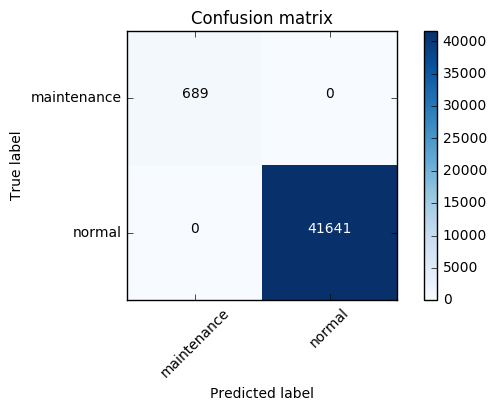

[[  689     0]
 [    0 41641]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       689
     normal       1.00      1.00      1.00     41641

avg / total       1.00      1.00      1.00     42330

 ====== Scores on the test set ==================


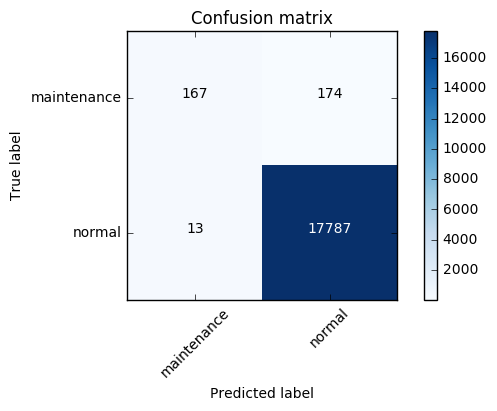

[[  167   174]
 [   13 17787]]
accuracy: 0.989691858222
             precision    recall  f1-score   support

maintenance       0.93      0.49      0.64       341
     normal       0.99      1.00      0.99     17800

avg / total       0.99      0.99      0.99     18141

Feature ranking:
0. LM-41BAL380.drv_Frequentie (0.260541)
1. LM-41BAL380.drv_Koppel (0.177131)
2. LM-41BAL380.drv_Snelheid (0.214568)
3. LM-41BAL380.drv_Stroom (0.185132)
4. LM-41BAL380.drv_Temperatuur (0.162628)


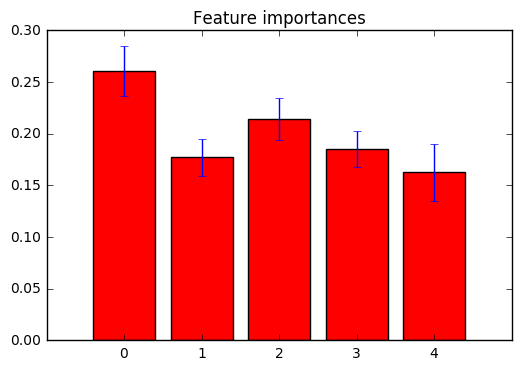


 2 of 2 - Drive: LM-41BAL300.drv
 ====== Scores on the train set ==================


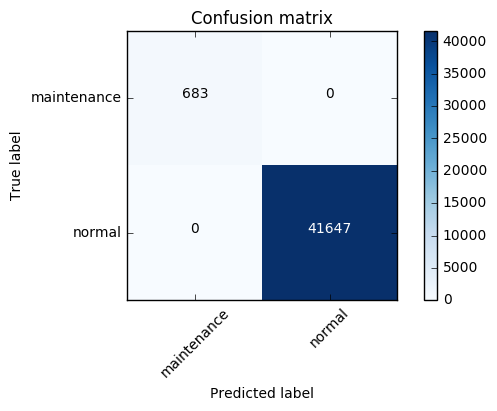

[[  683     0]
 [    0 41647]]
             precision    recall  f1-score   support

maintenance       1.00      1.00      1.00       683
     normal       1.00      1.00      1.00     41647

avg / total       1.00      1.00      1.00     42330

 ====== Scores on the test set ==================


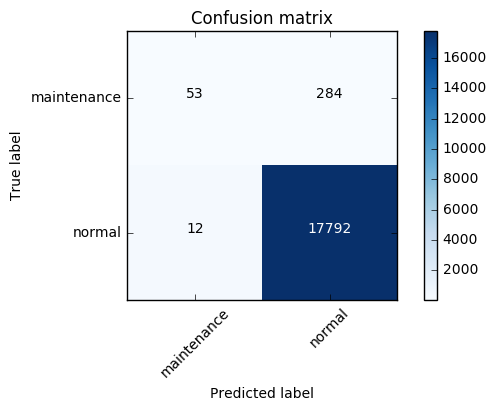

[[   53   284]
 [   12 17792]]
accuracy: 0.983683369164
             precision    recall  f1-score   support

maintenance       0.82      0.16      0.26       337
     normal       0.98      1.00      0.99     17804

avg / total       0.98      0.98      0.98     18141

Feature ranking:
0. LM-41BAL300.drv_Frequentie (0.205876)
1. LM-41BAL300.drv_Koppel (0.177949)
2. LM-41BAL300.drv_Snelheid (0.228769)
3. LM-41BAL300.drv_Stroom (0.202227)
4. LM-41BAL300.drv_Temperatuur (0.185179)


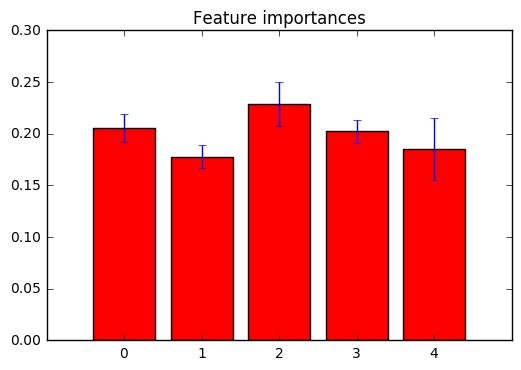

Accuracy of present model: 0.983683369164
LM-41BAL300.drv
Accuracy of control model fit: 0.981423295298
             precision    recall  f1-score   support

maintenance       0.00      0.00      0.00       337
     normal       0.98      1.00      0.99     17804

avg / total       0.96      0.98      0.97     18141

[[    0   337]
 [    0 17804]]
LM-41BAL380.drv
Accuracy of original control model: 0.989691858222
--------------------------------------------------------


//anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
drives = ["LM-41BAL380.drv", "LM-41BAL300.drv","LM-41SHL009.2.drv", "LM-41BFL060.1.drv", 
          "LM-41BFL030.1.drv", "LM-41SHL015.drv", "LM-55BRL041.drv", "LM-34CHP102.drv", "LM-41SHL009.1.drv","LM-34LBL102.1.drv"]     
drives = drives[0:2]


#drives = ["LM-41BAL380.drv", "LM-41BAL300.drv"]      
first_time = True        
for index, output_file in enumerate(drives):
    seq = str(index+1)+" of "+str(len(drives))
    train, test, columns, target, name = process_drive_file(output_file,seq)      
    model, predictions, accu, conf = rf_class_drive(train, test, columns, target, name)
    if first_time:
        fitfix = model.fit(train[columns], train[target].values.ravel())
        drive_model = re.search('LM.+\.drv',columns[1]).group(0)
        accu_model = accu
        first_time = False
    else:
        pred = fitfix.predict(test[columns])
        print("Accuracy of present model:", accu)
        print(re.search('LM.+\.drv',columns[1]).group(0))
        print(" ================================================= ")
        print("Accuracy of control model fit:", accuracy_score(pred, test[target]))
        print(classification_report(test[target], pred))
        print(confusion_matrix(test[target], pred))
        print(drive_model)
        print(" =================================================")
        print("Accuracy of original control model:", accu_model)
        print("--------------------------------------------------------")


### Key Findings
* The prediction rate in general for all drives are good with accuracy higher than 0,95.
* Not all drives demonstrated a good recall or precision result. 
* The reutilization of one model to another equipment still maintained the accuracy to a reasonable level for some drives. However, a deeper analysis is needed to understand if it is possible to generalize the model to include different drives. 
* When it comes to feature importance, there seems to be two clusters of drivers. One where variables are somehow balanced, and another where we find fewer features with much higher impact. It is important to understand better how accurate is the  information being captured by different drives. 
* It would be necessary to clarify the gap between the time the equipment comes back to a normal state, and the time the notification is closed in SAP. This gap may generate inconsistent feedback to a prediction model. 